In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [ ]:

# 1. Import CSV Files
# Load datasets from local system
customer_df = pd.read_csv(r"/Large_Customers_Dataset.csv")
transaction_df = pd.read_csv(r"/Large_Transactions_Dataset.csv")
support_df = pd.read_csv(r"/Large_Transactions_Dataset.csv")



In [ ]:
from sklearn.impute import KNNImputer
# Apply KNN Imputer
data_imputer = KNNImputer(n_neighbors=5)
data_cleaned = pd.DataFrame(data_imputer.fit_transform(data), columns=data.columns)
# Check for missing values
print("Missing Values After Imputation:")
print(data_cleaned.isnull().sum())


Missing Values After Imputation:
CustomerID    0
Name          0
Email         0
Phone         0
Country       0
dtype: int64


In [ ]:
# Detecting outliers
iso = IsolationForest(contamination=0.01, random_state=42)

# Check if 'target' column exists before dropping
if 'target' in data_cleaned.columns:
    data_cleaned['Anomaly'] = iso.fit_predict(data_cleaned.drop(columns=['target']))
else:
    # If 'target' column doesn't exist, use all columns for anomaly detection
    data_cleaned['Anomaly'] = iso.fit_predict(data_cleaned)

data_cleaned = data_cleaned[data_cleaned['Anomaly'] == 1].drop(columns=['Anomaly'])
print(f"Number of Outliers Removed: {len(data) - len(data_cleaned)}")

Number of Outliers Removed: 50


In [12]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the Three Datasets
customers = pd.read_csv("Large_Customers_Dataset.csv")
tickets = pd.read_csv("Large_Support_Tickets_Dataset.csv")
transactions = pd.read_csv("Large_Transactions_Dataset.csv")

# Step 2: Merge Datasets on the common key "CustomerID"
merged_data = customers.merge(tickets, on="CustomerID", how="outer") \
                       .merge(transactions, on="CustomerID", how="outer")

# Merged dataset columns may include:
# ['CustomerID', 'Name', 'Email', 'Phone', 'Country', 'TicketID', 'IssueType',
#  'Timestamp', 'ResolutionTime', 'TransactionID', 'Date', 'Amount', 'PaymentMethod']

# Step 3: Drop non-informative columns (IDs, names, emails, timestamps, etc.)
data = merged_data.drop(columns=["CustomerID", "Name", "Email", "Phone", "TicketID", "TransactionID", "Timestamp", "Date"])

# For this example, we define the target variable as "IssueType"
# and use the remaining columns as features (Country, ResolutionTime, Amount, PaymentMethod).
X = data.drop(columns=["IssueType"])
y = data["IssueType"]

# Step 4: Encode Categorical Features
# Encode features like Country and PaymentMethod.
categorical_features = ["Country", "PaymentMethod"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode the target variable "IssueType"
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y.astype(str))

# Check initial class distribution
print("Initial class distribution:\n", pd.Series(y_encoded).value_counts())

# Step 5: Handle Missing Values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 6: Outlier Detection using IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
inlier_mask = iso.fit_predict(X_imputed)
X_cleaned = X_imputed[inlier_mask == 1]
y_cleaned = y_encoded[inlier_mask == 1]

# Step 7: Address Imbalanced Classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

# Print class distribution after applying SMOTE
print("\nClass distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())


Initial class distribution:
 5    2438
0    1443
3    1400
4    1391
2    1354
1    1293
Name: count, dtype: int64

Class distribution after SMOTE:
 5    2438
1    2438
3    2438
0    2438
2    2438
4    2438
Name: count, dtype: int64


building and training the model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Accuracy: 0.2662
Precision: 0.2265
Recall: 0.2662
ROC AUC Score: 0.6159

Classification Report:
                  precision    recall  f1-score   support

  Account Locked       0.20      0.13      0.16       531
     Login Issue       0.18      0.39      0.24       464
 Payment Problem       0.33      0.02      0.03       502
   Product Query       0.20      0.24      0.22       471
Technical Glitch       0.00      0.00      0.00       453
             nan       0.42      0.81      0.56       505

        accuracy                           0.27      2926
       macro avg       0.22      0.26      0.20      2926
    weighted avg       0.23      0.27      0.20      2926



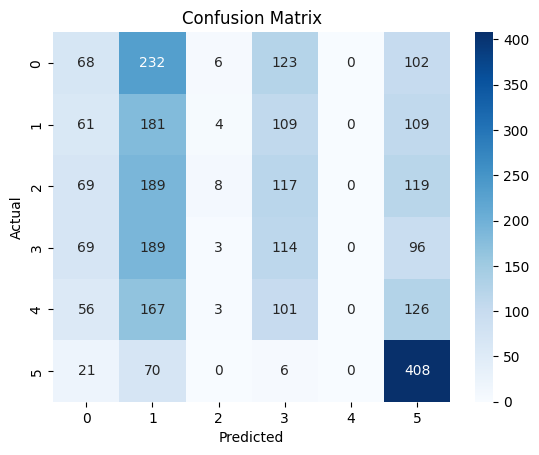

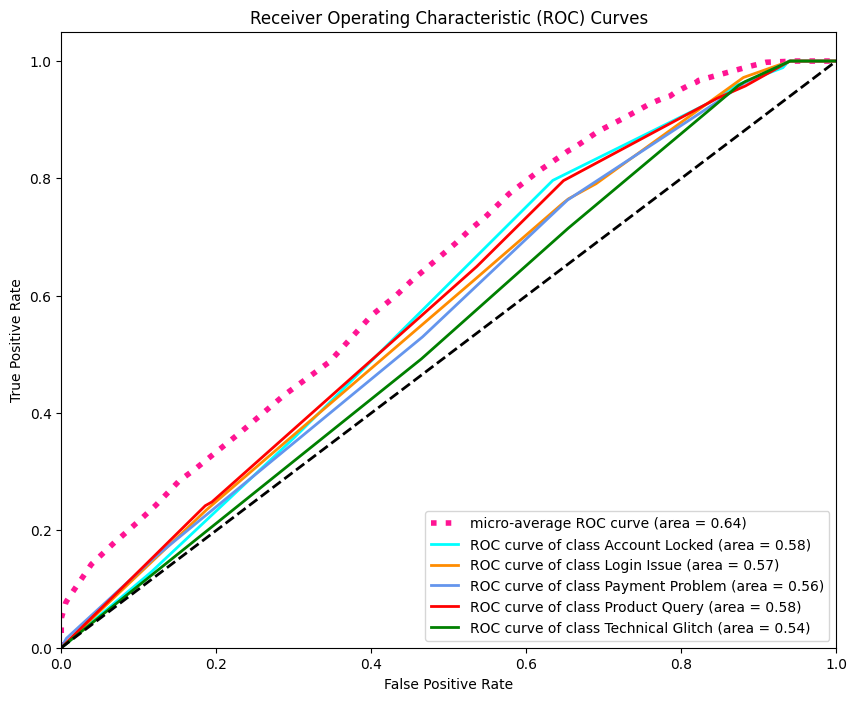

In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the Three Datasets
customers = pd.read_csv("Large_Customers_Dataset.csv")
tickets = pd.read_csv("Large_Support_Tickets_Dataset.csv")
transactions = pd.read_csv("Large_Transactions_Dataset.csv")

# Step 2: Merge Datasets on the common key "CustomerID"
merged_data = customers.merge(tickets, on="CustomerID", how="outer") \
                       .merge(transactions, on="CustomerID", how="outer")

# The merged dataset contains columns such as:
# ['CustomerID', 'Name', 'Email', 'Phone', 'Country', 'TicketID', 'IssueType',
#  'Timestamp', 'ResolutionTime', 'TransactionID', 'Date', 'Amount', 'PaymentMethod']

# Step 3: Drop non-informative columns (identifiers and timestamps)
data = merged_data.drop(columns=["CustomerID", "Name", "Email", "Phone", "TicketID", "TransactionID", "Timestamp", "Date"])

# Now, data columns include:
# ['Country', 'IssueType', 'ResolutionTime', 'Amount', 'PaymentMethod']

# For this example, we define the target variable as "IssueType"
# and use the rest as features.
X = data.drop(columns=["IssueType"])
y = data["IssueType"]

# Step 4: Encode categorical features in X (e.g., Country and PaymentMethod)
categorical_features = ["Country", "PaymentMethod"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode the target variable (IssueType)
target_le = LabelEncoder()
y = target_le.fit_transform(y.astype(str))

# Step 5: Handle missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 6: Outlier Detection using IsolationForest (applied on features)
iso = IsolationForest(contamination=0.01, random_state=42)
outlier_preds = iso.fit_predict(X_imputed)
# Retain only the inliers (where the prediction equals 1)
X_cleaned = X_imputed[outlier_preds == 1]
y_cleaned = y[outlier_preds == 1]

# Step 7: Address imbalanced classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42)

# Step 9: Build and Train the Decision Tree Classifier
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Step 10: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Step 11: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # using weighted average for multi-class
recall = recall_score(y_test, y_pred, average='weighted')

# Compute ROC AUC Score
# For multi-class, we use the 'ovr' (one-vs-rest) strategy with weighted average
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# Step 12: Display the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test (true labels) and y_pred_proba (predicted probabilities) are available
# and target_le is the LabelEncoder used for the target variable.

# Determine the number of classes and binarize the true labels
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average ROC curve (area = {roc_auc['micro']:.2f})",
         color="deeppink", linestyle=":", linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {target_le.classes_[i]} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()



Accuracy: 0.2932
Precision: 0.2581
Recall: 0.2932
ROC AUC Score: 0.6574

Classification Report:
                  precision    recall  f1-score   support

  Account Locked       0.27      0.10      0.14       531
     Login Issue       0.16      0.09      0.12       464
 Payment Problem       0.22      0.19      0.20       502
   Product Query       0.23      0.29      0.25       471
Technical Glitch       0.20      0.21      0.20       453
             nan       0.45      0.88      0.60       505

        accuracy                           0.29      2926
       macro avg       0.26      0.29      0.25      2926
    weighted avg       0.26      0.29      0.25      2926



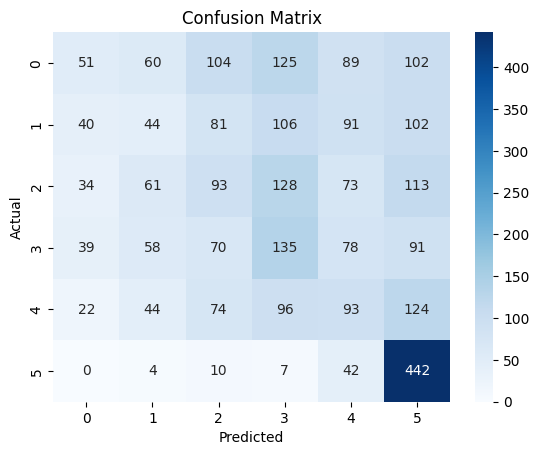

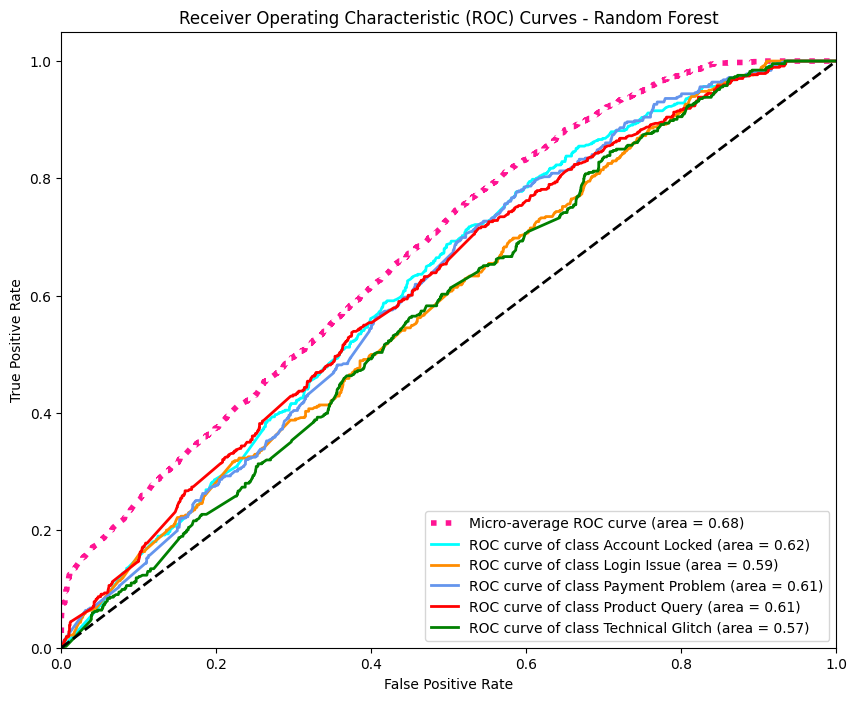

In [16]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the Three Datasets
customers = pd.read_csv("Large_Customers_Dataset.csv")
tickets = pd.read_csv("Large_Support_Tickets_Dataset.csv")
transactions = pd.read_csv("Large_Transactions_Dataset.csv")

# Step 2: Merge Datasets on the common key "CustomerID"
merged_data = customers.merge(tickets, on="CustomerID", how="outer") \
                       .merge(transactions, on="CustomerID", how="outer")

# Merged columns might include:
# ['CustomerID', 'Name', 'Email', 'Phone', 'Country', 'TicketID', 'IssueType',
#  'Timestamp', 'ResolutionTime', 'TransactionID', 'Date', 'Amount', 'PaymentMethod']

# Step 3: Drop non-informative columns (identifiers and timestamps)
data = merged_data.drop(columns=["CustomerID", "Name", "Email", "Phone", "TicketID", "TransactionID", "Timestamp", "Date"])

# Now, the dataset contains:
# ['Country', 'IssueType', 'ResolutionTime', 'Amount', 'PaymentMethod']

# For this example, we define the target variable as "IssueType"
X = data.drop(columns=["IssueType"])
y = data["IssueType"]

# Step 4: Encode categorical features (e.g., Country and PaymentMethod)
categorical_features = ["Country", "PaymentMethod"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Also encode the target variable (IssueType)
target_le = LabelEncoder()
y = target_le.fit_transform(y.astype(str))

# Step 5: Handle missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 6: Outlier Detection using IsolationForest (applied on features)
iso = IsolationForest(contamination=0.01, random_state=42)
outlier_preds = iso.fit_predict(X_imputed)
X_cleaned = X_imputed[outlier_preds == 1]
y_cleaned = y[outlier_preds == 1]

# Step 7: Address imbalanced classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42)

# Step 9: Build and Train the Advanced Random Forest Model
clf = RandomForestClassifier(
    random_state=42,
    n_estimators=30,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    max_samples=0.8,
    warm_start=True
)
clf.fit(X_train, y_train)

# Step 10: Make Predictions on the Test Set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Step 11: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# For multi-class ROC AUC, we use the one-vs-rest strategy
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# Step 12: Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test and y_pred_proba are available from the Random Forest model,
# and target_le is the LabelEncoder used to encode the target variable.
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (area = {roc_auc['micro']:.2f})",
         color="deeppink", linestyle=":", linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {target_le.classes_[i]} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves - Random Forest")
plt.legend(loc="lower right")
plt.show()



In [26]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Load the Three Datasets
# -----------------------------
customers = pd.read_csv("Large_Customers_Dataset.csv")
tickets = pd.read_csv("Large_Support_Tickets_Dataset.csv")
transactions = pd.read_csv("Large_Transactions_Dataset.csv")

# -----------------------------
# Step 2: Merge Datasets on the common key "CustomerID"
# -----------------------------
merged_data = customers.merge(tickets, on="CustomerID", how="outer") \
                       .merge(transactions, on="CustomerID", how="outer")

# Columns in merged_data may include:
# ['CustomerID', 'Name', 'Email', 'Phone', 'Country', 'TicketID', 'IssueType',
#  'Timestamp', 'ResolutionTime', 'TransactionID', 'Date', 'Amount', 'PaymentMethod']

# -----------------------------
# Step 3: Drop non-informative columns
# -----------------------------
data = merged_data.drop(columns=["CustomerID", "Name", "Email", "Phone", "TicketID", "TransactionID", "Timestamp", "Date"])

# For this example, we use:
# Features: Country, ResolutionTime, Amount, PaymentMethod
# Target: IssueType
X = data.drop(columns=["IssueType"])
y = data["IssueType"]

# -----------------------------
# Step 4: Encode categorical features and target
# -----------------------------
categorical_features = ["Country", "PaymentMethod"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode the target variable "IssueType"
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y.astype(str))

# -----------------------------
# Step 5: Handle missing values using KNN Imputer
# -----------------------------
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# -----------------------------
# Step 6: Outlier Detection using IsolationForest
# -----------------------------
iso = IsolationForest(contamination=0.01, random_state=42)
inlier_mask = iso.fit_predict(X_imputed)
X_cleaned = X_imputed[inlier_mask == 1]
y_cleaned = y_encoded[inlier_mask == 1]

# -----------------------------
# Step 7: Address imbalanced classes using SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

# -----------------------------
# Step 8: Split data into training and testing sets
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42)

# -----------------------------
# Step 9: Build and Train the Decision Tree Model
# -----------------------------
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# -----------------------------
# Step 10: Make Predictions
# -----------------------------
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)

# -----------------------------
# Step 11: Evaluate the Model
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# ROC AUC Score: For multi-class, use one-vs-rest ('ovr')
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))



Accuracy: 26.6234%
Precision: 0.2265
Recall: 0.2662
ROC AUC Score: 0.6159

Classification Report:
                  precision    recall  f1-score   support

  Account Locked       0.20      0.13      0.16       531
     Login Issue       0.18      0.39      0.24       464
 Payment Problem       0.33      0.02      0.03       502
   Product Query       0.20      0.24      0.22       471
Technical Glitch       0.00      0.00      0.00       453
             nan       0.42      0.81      0.56       505

        accuracy                           0.27      2926
       macro avg       0.22      0.26      0.20      2926
    weighted avg       0.23      0.27      0.20      2926



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Load the Three Datasets
# -----------------------------
customers = pd.read_csv("Large_Customers_Dataset.csv")
tickets = pd.read_csv("Large_Support_Tickets_Dataset.csv")
transactions = pd.read_csv("Large_Transactions_Dataset.csv")

# -----------------------------
# Step 2: Merge Datasets on the common key "CustomerID"
# -----------------------------
merged_data = customers.merge(tickets, on="CustomerID", how="outer") \
                       .merge(transactions, on="CustomerID", how="outer")

# The merged_data is assumed to have columns such as:
# ['CustomerID', 'Name', 'Email', 'Phone', 'Country', 'TicketID', 'IssueType',
#  'Timestamp', 'ResolutionTime', 'TransactionID', 'Date', 'Amount', 'PaymentMethod']

# -----------------------------
# Step 3: Drop non-informative columns
# -----------------------------
data = merged_data.drop(columns=["CustomerID", "Name", "Email", "Phone", "TicketID", "TransactionID", "Timestamp", "Date"])

# For this example, we use:
# Features: Country, ResolutionTime, Amount, PaymentMethod
# Target: IssueType
X = data.drop(columns=["IssueType"])
y = data["IssueType"]

# -----------------------------
# Step 4: Encode Categorical Features and Target
# -----------------------------
# Encode features like 'Country' and 'PaymentMethod'
categorical_features = ["Country", "PaymentMethod"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode the target variable "IssueType"
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y.astype(str))

# -----------------------------
# Step 5: Handle Missing Values using KNN Imputer
# -----------------------------
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# -----------------------------
# Step 6: Outlier Detection using IsolationForest
# -----------------------------
iso = IsolationForest(contamination=0.01, random_state=42)
inlier_mask = iso.fit_predict(X_imputed)
X_cleaned = X_imputed[inlier_mask == 1]
y_cleaned = y_encoded[inlier_mask == 1]

# -----------------------------
# Step 7: Address Imbalanced Classes using SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

# -----------------------------
# Step 8: Split the Data into Training and Testing Sets
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42)

# -----------------------------
# Step 9: Build and Train the Advanced Random Forest Model
# -----------------------------
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=30,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    max_samples=0.8,
    warm_start=True
)
rf_model.fit(X_train, y_train)

# -----------------------------
# Step 10: Make Predictions
# -----------------------------
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# -----------------------------
# Step 11: Evaluate the Model
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# For multi-class, compute ROC AUC using one-vs-rest strategy
if len(np.unique(y_test)) > 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

Accuracy: 29.3233%
Precision: 0.2581
Recall: 0.2932
ROC AUC Score: 0.6574

Classification Report:
                  precision    recall  f1-score   support

  Account Locked       0.27      0.10      0.14       531
     Login Issue       0.16      0.09      0.12       464
 Payment Problem       0.22      0.19      0.20       502
   Product Query       0.23      0.29      0.25       471
Technical Glitch       0.20      0.21      0.20       453
             nan       0.45      0.88      0.60       505

        accuracy                           0.29      2926
       macro avg       0.26      0.29      0.25      2926
    weighted avg       0.26      0.29      0.25      2926

